# Grover's Algorithm

Grover's algorithm is an oracle-based algorithm, proposed by Lov Grover. Theoretically, it allows us to perform a search of an unstructured database in $O(\sqrt{N})$ rather than $O(N)$. Any problem that you can verify a solution of easily can fall into this category. Think:
  - Integer Factors: is number N divisible by x? Easy to verify, but finding x in the first place is hard.
  - Database search: does the database contain x?
  - Travelling salesman: shortest route to visit all cities exactly once, returning to original city.

More generally, if we have a function $y=f(x)$ then Grover's Algorithm allows us to calculate x given y, i.e. the inverse function. More formally, the problem can be written as


In [1]:
import os
import sys
import numpy as np
from dotenv import load_dotenv
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import *
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import (SamplerV2 as Sampler)
from qiskit.primitives import (BackendSamplerV2)
from requests.packages import target

In [2]:
# Fetch API token and instance CRN. Stored locally in a .env file and not pushed, for obvious reasons.
load_dotenv()
API_TOKEN = os.getenv('API_TOKEN')
CRN = os.getenv('CRN')

In [20]:
# Connect to least busy backend.
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from ibmq_connect import ibmq_connect_least_busy
backend = ibmq_connect_least_busy(API_TOKEN, CRN)

qiskit_runtime_service._discover_account:WARNING:2025-11-08 15:03:20,150: Loading account with the given token. A saved account will not be used.


Name: ibm_torino
Version: 2
No. of qubits: 133



## 1. Background
### 1.1 Brief Overview

There's lots of background out there, which I won't go into, but the general algorithm outline looks like:
   - 1. Initialise quantum register of n-qubits in $|0\rangle$ state.
   - 2. Apply a Hadamard gate to each qubit, so that the register is in a uniform superposition.
   - 3. Repeat:
        - Implement the Oracle.
        - Apply Grover diffusion operator.
   - 4. Measure

The Oracle's job is to take the superposition state and mark the target state without revealing it. In this case, the Oracle introduces a phase factor of -1 on the target state. So if the target state had an amplitude of say 0.8, then the amplitude would become -0.8.

The diffusion operator inverts all the probability amplitudes about their mean, which is the equal superposition of all the basis states. This has the effect of increasing the probability of the target state.

Repeat these steps enough times (of order $\sqrt{N}$), and the target state's probability approaches 1.

This algorithm (in a perfect system) speeds up the search because we can apply these transformations to every superposition at the same time.

3Blue1Brown has a good visualisation on Grover's algorithm here: https://www.youtube.com/watch?v=RQWpF2Gb-gU&t=1118s.
Andy Matuschak and Michael Nielsen have a good write-up here: https://quantum.country/search

To start, I will imagine a 3-qubit circuit, spanning integers 0-7. I will also introduce a target integer to look for: 5 = '101'. 

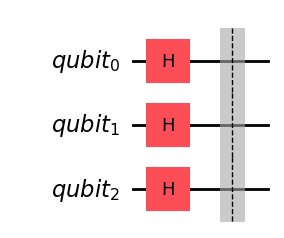

In [4]:
# integers to search for
_target_integers: list[int] = [5]

# find number of qubits required
_num_qubits = max(_target_integers).bit_length()

# binary representations of search values in little endian
_targets: list[str] = [format(num, f'0{_num_qubits}b')[::-1] for num in _target_integers]

# number of iterations of the algorithm
_num_its = round(np.pi * np.sqrt(2**_num_qubits) * 0.25)

# n-qubit quantum register
_qr: QuantumRegister = QuantumRegister(_num_qubits, "qubit")

def initialise(n: int):
    '''
    Initialise the quantum circuit with n qubits in equal superposition
    :param n: number of qubits
    :return: quantum circuit with n-qubits
    '''

    qc = QuantumCircuit(_qr)

    # equal superposition
    qc.h(_qr)

    qc.barrier()

    return qc

qc = initialise(_num_qubits)
qc.draw('mpl')

### 1.2 Oracle = Black Box
It feels strange to hard-code in a target and build an oracle around it, since it raises the question of how do you build an oracle without knowing the target? If you can't do this, then it renders the whole thing redundant.

Everywhere I look on the internet just describe general Oracles as a sort of hand-wavy black box type implementation that boils down to True/False via a long series of logic gates. Oracles seem to be more conceptual than anything, but the point is they could represent anything you want: a database query, a long function, a simple true or false. They seem to allow to build a general model for proof of concept. Something you could use as a tool to investigate complexities.

For now, hard-coding an Oracle that directly queries the target will let me implement the algorithm, and move on from this brain-trickery. I still need to understand the abstractions that allow me to do that, however.

## 2 Building Framework
## 2.1 Using the Ancilla
In their Quantum Country guide, A.Matuschak and M.Nielsen describe a nice method for reflecting across the target state $|s\rangle$, using $$X\frac{|0\rangle - |1\rangle}{2} = -\frac{|0\rangle - |1\rangle}{2}.$$

In other words, applying a NOT gate to a state to $|-\rangle$ introduces a phase factor of -1. To use this I will introduce an extra qubit ('ancilla'), that can be used as a sort of workspace to direct logic at. Starting the ancilla at $|-\rangle$ means a multi-controlled NOT gate can be applied to it. If the NOT gate aligns with our target space, then a phase factor is introduced, otherwise nothing happens.

To achieve this, we need to X gate all of the qubits that correspond to '0' in our bitstring, so that it is now $|1 1.. 1\rangle$. Then we can apply a multi-NOT gate (MCX) to the ancilla, where all of the other qubits are controls. If the state is $|1 1.. \rangle$ then the not gate is applied to the ancilla, introducing the factor of -1, otherwise nothing. All that remains is to return the relevant qubits back to 0.

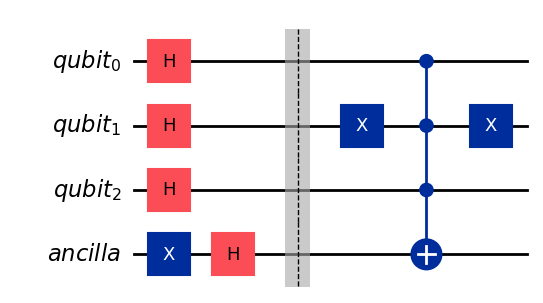

In [5]:
qc = QuantumCircuit(_qr)

# equal superposition
qc.h(_qr)

# set ancilla qubit as a workspace state
ancilla = QuantumRegister(1, "ancilla")
qc.add_register(ancilla)
qc.x(ancilla)
qc.h(ancilla)
qc.barrier()

target = _targets[0]

def flip_state(target: str, qc: QuantumCircuit, state:str = '0'):
    '''
    Flips qubits of target state
    :param target: target state
    :
    '''
    for i, bit in enumerate(target):
        if bit == state: qc.x(i)


flip_state(target, qc)

qc.mcx(list(range(_num_qubits)), ancilla) # multi-controlled-not gate

flip_state(target, qc)

qc.draw('mpl')

### 2.2 Multi-controlled Z-Gate (MCZ).

Instead of using an ancilla, for our purpose, it is sufficient to introduce the phase factor with a multi-controlled Z gate. If all the controls are 1, then apply the Pauli Z-matrix, introducing the phase factor in the state. No ancilla needed. There is a decomposition of this as:
$$MCZ = H_{target} \cdot MCX \cdot H_{target}.$$

Once again using the MCX gate. Simple, and implementable. Though I think the ancilla feels easier to visualise, as you have something to direct the gates at.

In [6]:
def oracle_operator(n: int, targets: list[str]):
    '''
    Oracle function to phase-flip target states
    :param n: number of qubits
    :param targets: list of target states to phase-flip
    :return: oracle circuit
    '''
    # generate circuit
    oracle = QuantumCircuit(_qr, name='Oracle')

    # loop over target states
    for target in targets:

        # flip target state 0 -> 1.
        flip_state(target, oracle)

        # MCZ Gate on n-th qubit
        oracle.h(n-1)
        oracle.mcx(list(range(n-1)), n-1)
        oracle.h(n-1)

        # Undo relevant flips 1 -> 0.
        flip_state(target, oracle)

    return oracle

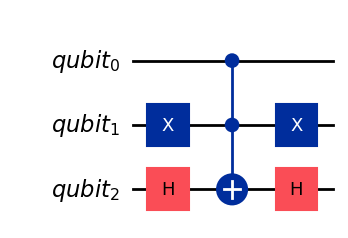

In [7]:
qc = oracle_operator(_num_qubits, _targets)
qc.draw('mpl')

### 2.3 Diffusion Operator
The diffusion operator feels simpler. It is a reflection about the equal superposition state, which inverts the probabilities about their mean. Thinking about the basis, this means flipping the phase of the $|00..0\rangle$ basis. Since the target state already has a phase factor it gets amplified more!
  -  Apply Hadamard Gates: mapping the current basis to the computational basis $|00..0\rangle$.
  -  Apply Pauli X-Gates to map $|00..0\rangle \rightarrow |11..1\rangle$
  -  Use a multi-controlled Z-Gate to flip the phase of $|11..1\rangle$.
  -  Apply Pauli X-Gates to map $|11..1\rangle \rightarrow |00..0\rangle$
  -  Apply Hadamard Gates to reverse basis change.
 

In [8]:
def diffusion_operator(n):
    '''
    Diffusion operator function to reflect in the |00..0> basis.
    :param n: number of qubits
    :return: diffusion operator circuit
    '''

    diffusion = QuantumCircuit(_qr, name='Diffusion Operator')

    # Hadamard and X Gate all states
    diffusion.h(_qr)
    diffusion.x(_qr)

    # MCZ Operator to the target state (|11...1>)
    diffusion.h(n-1)
    diffusion.mcx(list(range(n-1)), n-1)
    diffusion.h(n-1)

    # Reverse Hadamard and X Gates
    diffusion.x(_qr)
    diffusion.h(_qr)

    return diffusion

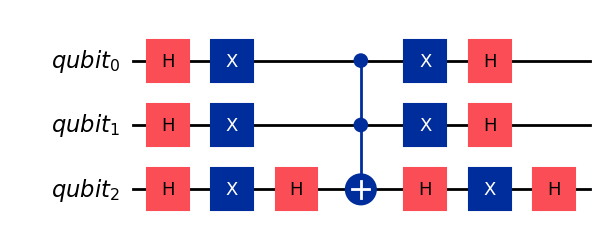

In [9]:
qc = diffusion_operator(_num_qubits)
qc.draw('mpl')

This is just like the Oracle, with a target state of $|00..0\rangle$, and an extra step of changing the basis before and after. It would make my function smaller, but maybe less clear what is going on.

### 2.4 Rinse and Repeat
We need to run the oracle diffuser this many iterations:
$$
\text{round}(\pi/4 \text{ arcsin}(1/\sqrt{N})-1/2) \approx \pi \frac{\sqrt{N}}{4},
$$
where $N$ is the number of items we're search through. Here $N=2^{n}$. The derivation of this can be seen in the earlier links from 3B1B and Quantum Country. 

In [10]:
def grovers_circuit(n, targets):
    '''
    Circuit representing Grover's algorithm
    :param n: number of qubits
    :param targets: list of target states
    :return: circuit containing Grover's algorithm
    '''
    grovers = initialise(n)

    for _ in range(_num_its):
        grovers.barrier()
        oracle = oracle_operator(n, targets)
        grovers.append(oracle,_qr)
        grovers.barrier()
        diff = diffusion_operator(n)
        grovers.append(diff, _qr)

    cr = ClassicalRegister(n)
    grovers.measure_all()
    return grovers

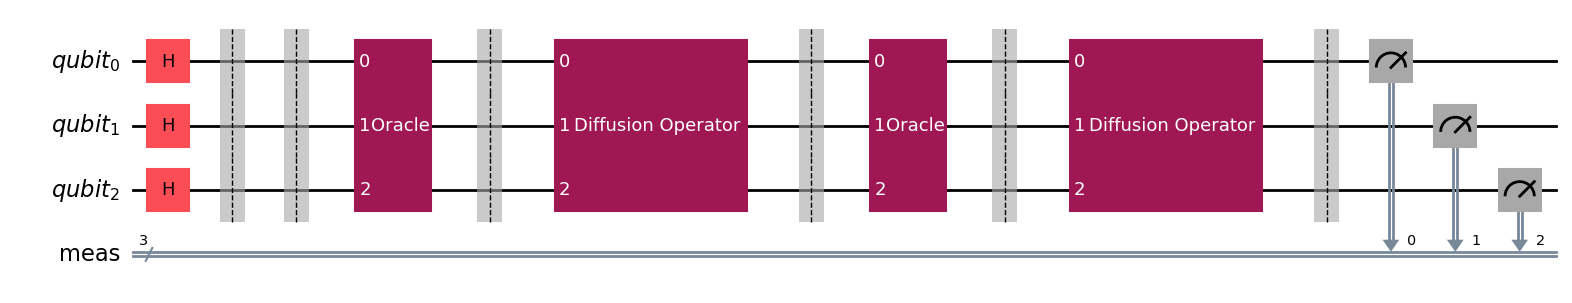

In [11]:
qc = grovers_circuit(_num_qubits, _targets)
qc.draw('mpl', style='iqp')

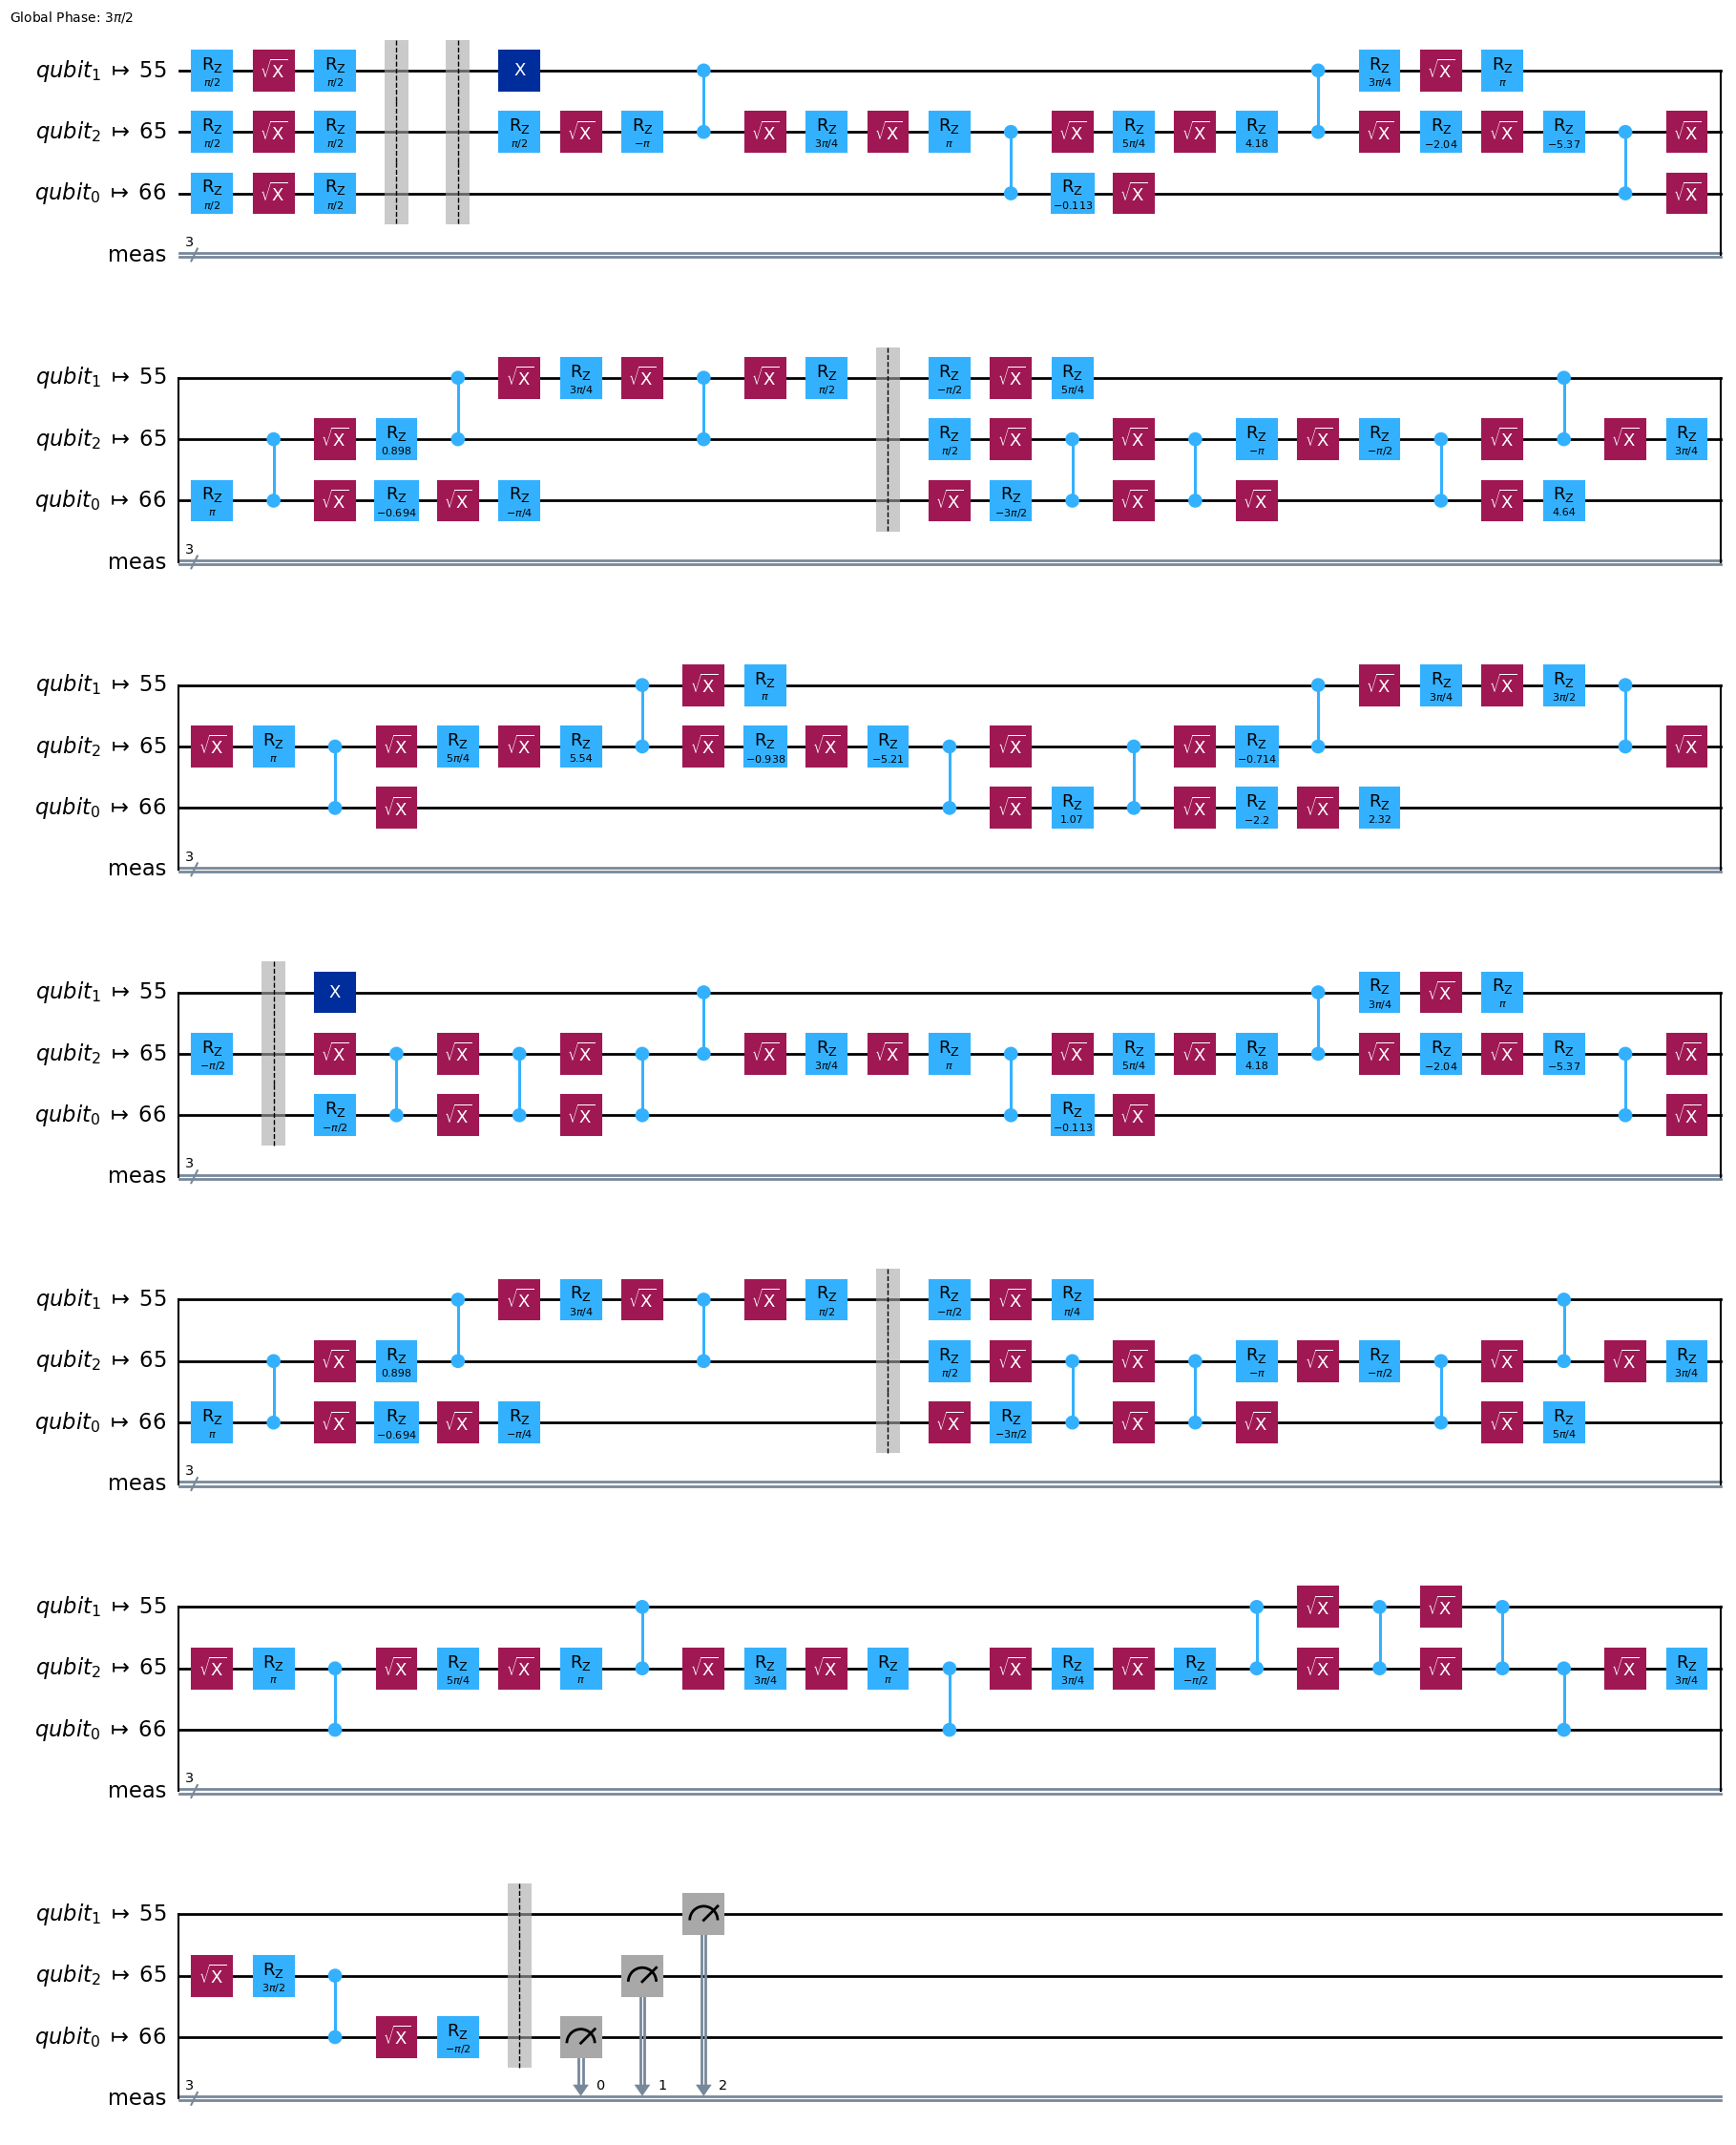

In [12]:
# Transpile
backend_target = backend.target
pm = generate_preset_pass_manager(target=backend_target, optimization_level=3)
qc_isa = pm.run(qc)
qc_isa.draw('mpl')

Hectic! That is a lot of operations given it is only checking through 8 numbers.

## 3. Testing
I will try pass this circuit 1000 times to see the distribution of results.

In [13]:
def run_grovers(n: int, targets: list[str], num_shots: int = 1000, on_hardware: bool = False):
    '''
    Function to run Grover's algorithm.
    :param n: number of wubits
    :param targets: list of target integers
    :return: counts
    '''
    # Generate Circuit
    grovers = grovers_circuit(n, targets)

    # Transpile
    backend_target = backend.target
    pm = generate_preset_pass_manager(target=backend_target, optimization_level=3)
    qc_isa = pm.run(grovers)

    if on_hardware:
        # Run Algorithm on Hardware
        sampler = Sampler(mode=backend)
        pubs = [qc_isa]
        job = sampler.run(pubs, shots=num_shots)
        res = job.result()
    else:
        # Run sample on quantum simulator of backend
        backend_sim = AerSimulator.from_backend(backend)
        sampler_sim = BackendSamplerV2(backend=backend_sim)
        job = sampler_sim.run([[qc_isa]], shots=num_shots)
        res = job.result()

    # get data in readable format
    bitstrings = res[0].data.meas.get_counts()
    counts = {int(bitstring, 2): count for bitstring, count in bitstrings.items()}
    plot_histogram(counts)

    return counts


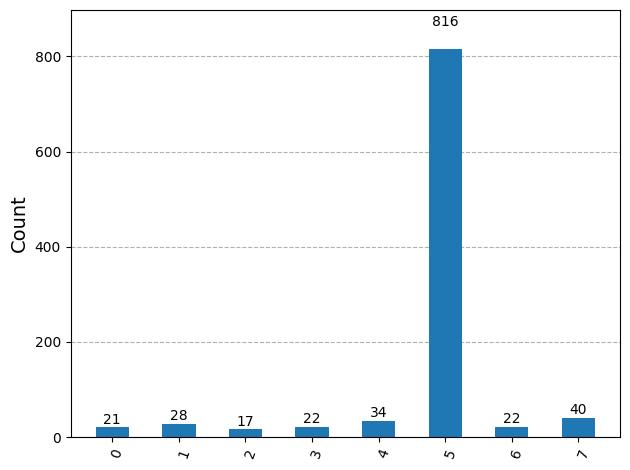

In [14]:
counts = run_grovers(_num_qubits, _targets, num_shots = 1000, on_hardware = False)
plot_histogram(counts)

Nice! ~82% of the results ended up being the right integer, with only two passes of the algorithm. Now on real hardware:

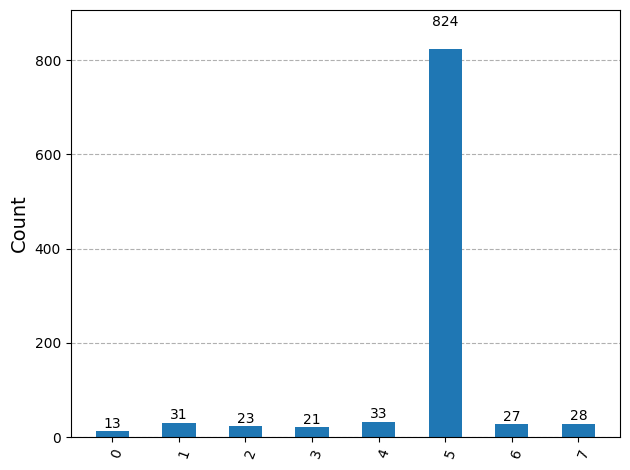

In [15]:
counts = run_grovers(_num_qubits, _targets, num_shots = 1000, on_hardware = True)
plot_histogram(counts)

Now to see how it handles two targets.

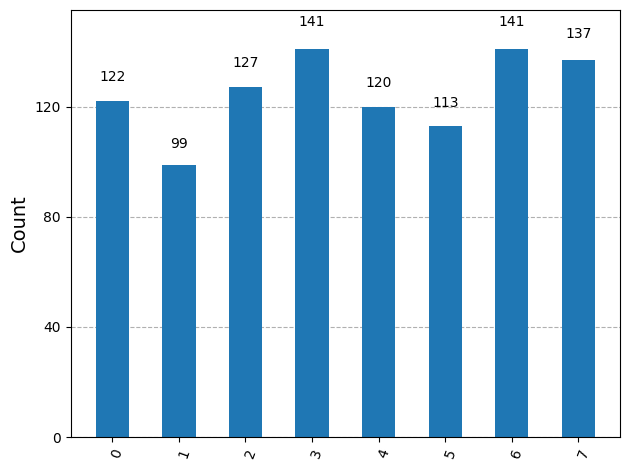

In [16]:
# integers to search for
_target_integers: list[int] = [5, 7]

# find number of qubits required
_num_qubits = max(_target_integers).bit_length()

# binary representations of search values in little endian
_targets: list[str] = [format(num, f'0{_num_qubits}b')[::-1] for num in _target_integers]

# number of iterations of the algorithm
_num_its = round(np.pi * np.sqrt(2**_num_qubits) * 0.25)

# n-qubit quantum register
_qr: QuantumRegister = QuantumRegister(_num_qubits, "qubit")

counts = run_grovers(_num_qubits, _targets, num_shots = 1000, on_hardware = False)
plot_histogram(counts)

Oh no! Not so good. Maybe it is not doing enough iterations because our search space is quite small.

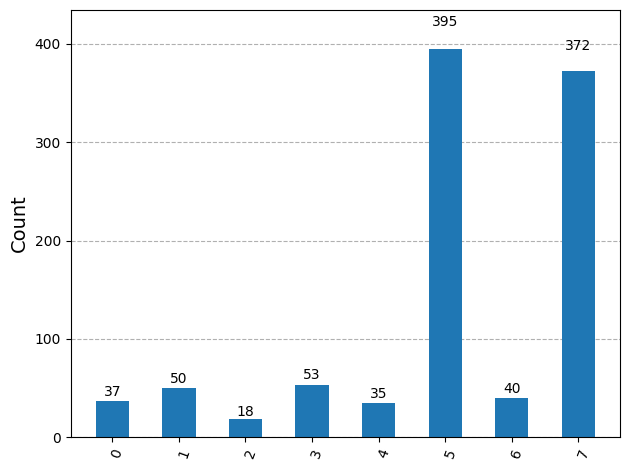

In [17]:
# number of iterations of the algorithm
_num_its = 4

counts = run_grovers(_num_qubits, _targets, num_shots = 1000, on_hardware = False)
plot_histogram(counts)

Perfect! Seems like it just needed more time to converge. What about big numbers?

In [18]:
# integers to search for
_target_integers: list[int] = [123]

# find number of qubits required
_num_qubits = max(_target_integers).bit_length()

# binary representations of search values in little endian
_targets: list[str] = [format(num, f'0{_num_qubits}b')[::-1] for num in _target_integers]

# number of iterations of the algorithm
_num_its = round(np.pi * np.sqrt(2**_num_qubits) * 0.25)

# n-qubit quantum register
_qr: QuantumRegister = QuantumRegister(_num_qubits, "qubit")

counts = run_grovers(_num_qubits, _targets, num_shots = 1000, on_hardware = True)

{31: 4, 66: 23, 18: 10, 112: 11, 50: 13, 72: 9, 97: 12, 82: 10, 4: 5, 19: 9, 20: 5, 64: 15, 2: 13, 65: 13, 32: 18, 42: 19, 43: 16, 11: 8, 9: 16, 120: 11, 70: 3, 8: 8, 13: 3, 34: 11, 105: 6, 100: 2, 25: 13, 101: 4, 60: 5, 96: 16, 69: 5, 115: 6, 98: 14, 33: 15, 26: 14, 86: 5, 107: 6, 74: 14, 121: 12, 1: 18, 118: 4, 116: 2, 51: 10, 46: 6, 17: 8, 56: 6, 91: 11, 79: 7, 44: 9, 75: 11, 93: 3, 52: 8, 40: 13, 106: 13, 73: 12, 37: 4, 10: 16, 58: 12, 59: 14, 83: 7, 27: 9, 114: 9, 21: 7, 47: 3, 38: 6, 0: 11, 5: 3, 48: 12, 36: 8, 92: 2, 16: 10, 3: 6, 90: 14, 41: 19, 24: 8, 122: 14, 71: 7, 23: 3, 89: 4, 99: 11, 76: 9, 123: 11, 28: 8, 102: 5, 29: 5, 22: 6, 53: 5, 124: 5, 80: 9, 14: 3, 45: 5, 110: 5, 113: 6, 6: 8, 104: 12, 68: 9, 39: 3, 88: 7, 84: 3, 94: 5, 111: 4, 77: 3, 54: 3, 61: 3, 67: 12, 57: 9, 95: 2, 49: 8, 62: 2, 12: 6, 108: 5, 87: 3, 81: 3, 126: 3, 30: 4, 35: 8, 103: 5, 125: 2, 127: 4, 55: 1, 63: 2, 78: 5, 85: 4, 119: 3, 7: 1, 109: 2, 15: 1, 117: 1}


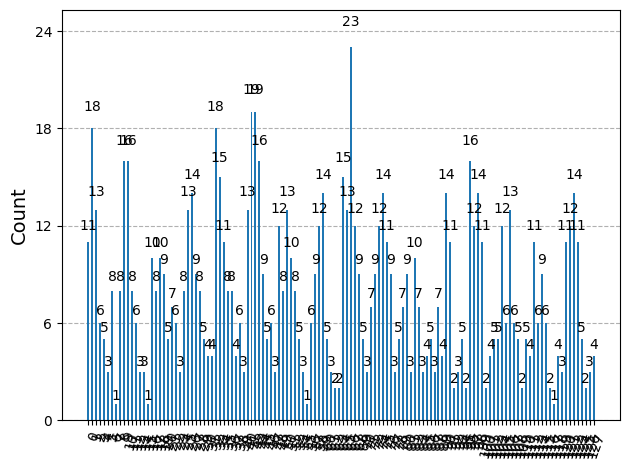

In [19]:
print(counts)
plot_histogram(counts)

Not great. I think with some fiddling and more experimenting perhaps I could get this to be accurate but it is likely that the noise in quantum computers is just too high to accurately calculate. However, it gives an idea as to what quantum computers may be able to do with advances in accuracy. I would like to delve deeper into the statistics here, and what is possible, but for now this serves as a proof of concept.